# **<span style="color:red">Imports</span>**

In [1]:
# Handy arrays
import numpy as np

# FFTs
import scipy.fft as fft
import scipy.fftpack as fftp

# Blind deconvolution
import skimage

# Custom modules
import lib.utils.utils as Utils
import lib.utils.plotting as Plotting
import lib.utils.otf as OTF
import lib.methods.distortion as Distortion
import lib.methods.tikhonov as TikhonovMethod
import lib.methods.bispectral as BispectralMethod
import lib.scripts as Scripts
import lib.vkr.sample_presets as SamplePresets

# **<span style="color:red">Reconstruction of simulated samples</span>**

## <span style="color:orange">**Samples init**</span>

### <span>**Samples**</span>

In [ ]:
sample_preset_1 = SamplePresets.SimulatedSamplePreset('Samples/Test_image_1.png', (slice(128, 2176), slice(1024, 3072)),
                                                      'Results_(VKR)/Simulated_Sample_1/',
                                                      10.0, None,
                                                      1e-4, 0.04, 1.5,
                                                      200,
                                                      1e-11,
                                                      1e-9, 0.3,
                                                      0.1)

In [2]:
sample_preset_1_noise = SamplePresets.SimulatedSamplePreset('Samples/Test_image_1.png', (slice(128, 2176), slice(1024, 3072)),
                                                            'Results_(VKR)/Simulated_Sample_1 (noise)/',
                                                            10.0, Utils.image_load('Samples/Test_noise_1.png'),
                                                            0.001, 0.1, 1.0,
                                                            200,
                                                            1e-8,
                                                            1e-4, 0.3,
                                                            0.1)

In [3]:
# Preset choice
selected_sample = sample_preset_1_noise

### <span>**Image**</span>

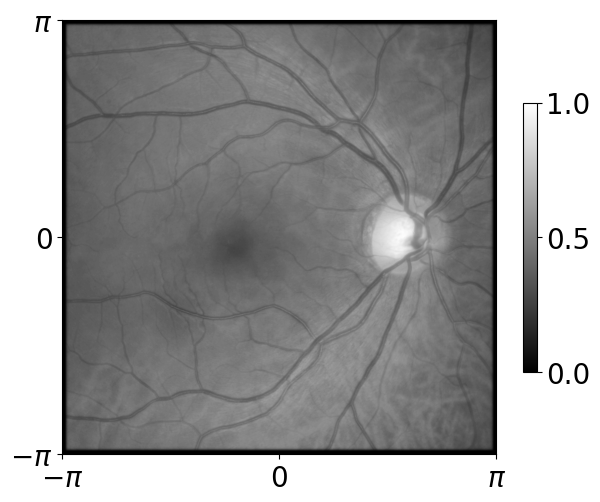

In [4]:
image = Utils.image_load(selected_sample.filepath, selected_sample.crop_slice)
window_func = Utils.create_super_gauss(image.shape, 10.8/11, 40, mode='square')
image *= window_func
image = Utils.image_normalize(image)
Plotting.plot_image(image)

In [4]:
Utils.image_save(Utils.image_crop_corners(image, ratio=selected_sample.crop_ratio), selected_sample.sample_folder + '1, original.png')

### <span>**Artificial defocus**</span>

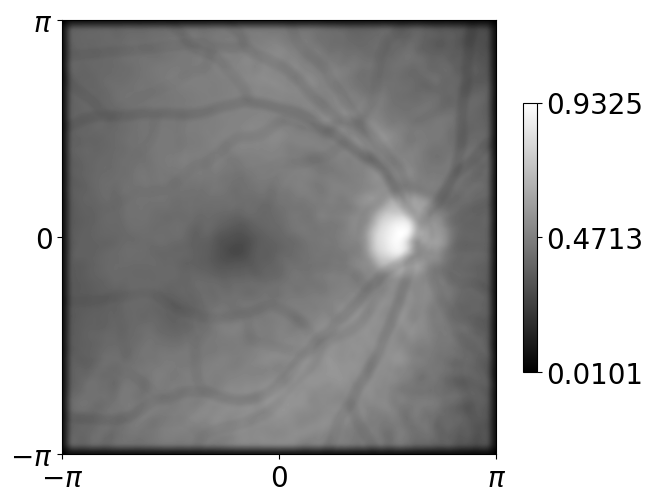

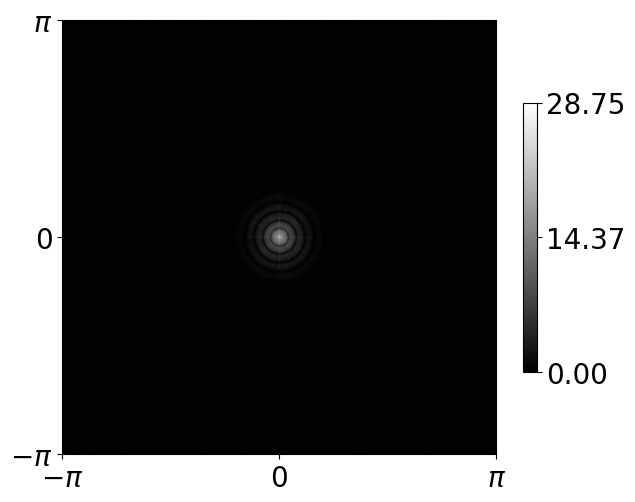

In [5]:
image_blurred = Distortion.image_distortion(image, a=selected_sample.defocus_param, additive_noise=selected_sample.additive_noise)
Plotting.plot_image(image_blurred)
Plotting.plot_spectrum(image_blurred)

In [6]:
Utils.image_save(Utils.image_crop_corners(image_blurred, ratio=selected_sample.crop_ratio), selected_sample.sample_folder + '2, observed.png')

## <span style="color:orange">**Restoration**</span>

### <span>**Defocus parameter estimation**</span>

Min defocus param is:  10.0
Other known mins:
[ 3.8  5.6  6.8 10.  12.1 12.4 13.1 13.5 14.8 16.2 16.5 17.2 17.4 17.7
 19.2]


10.0

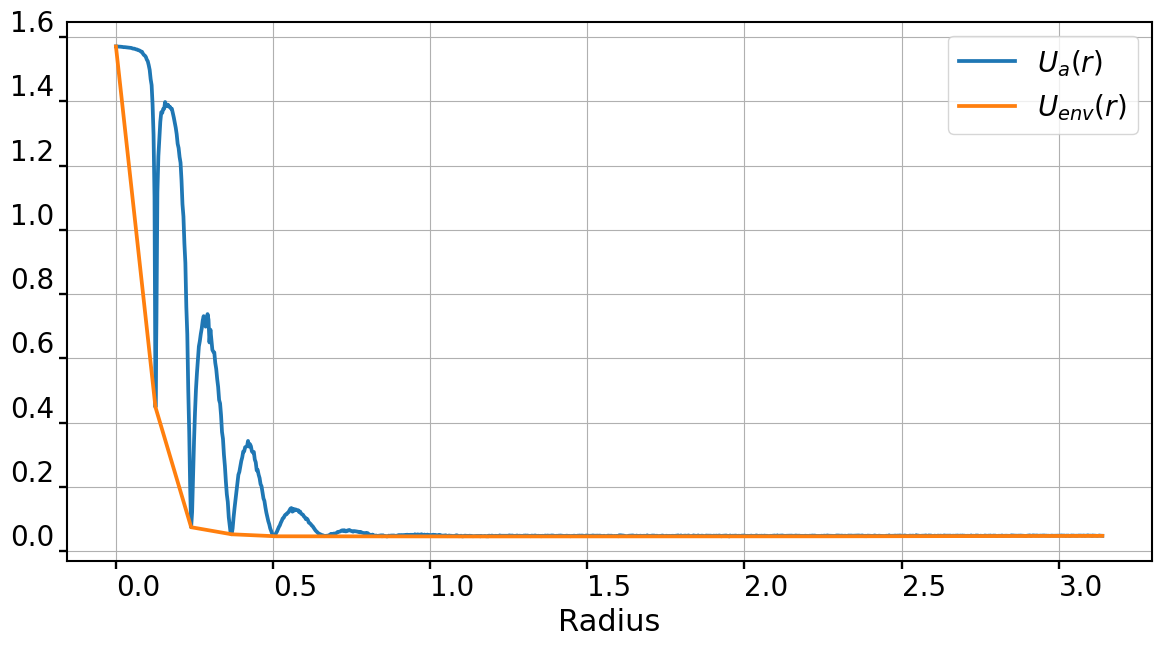

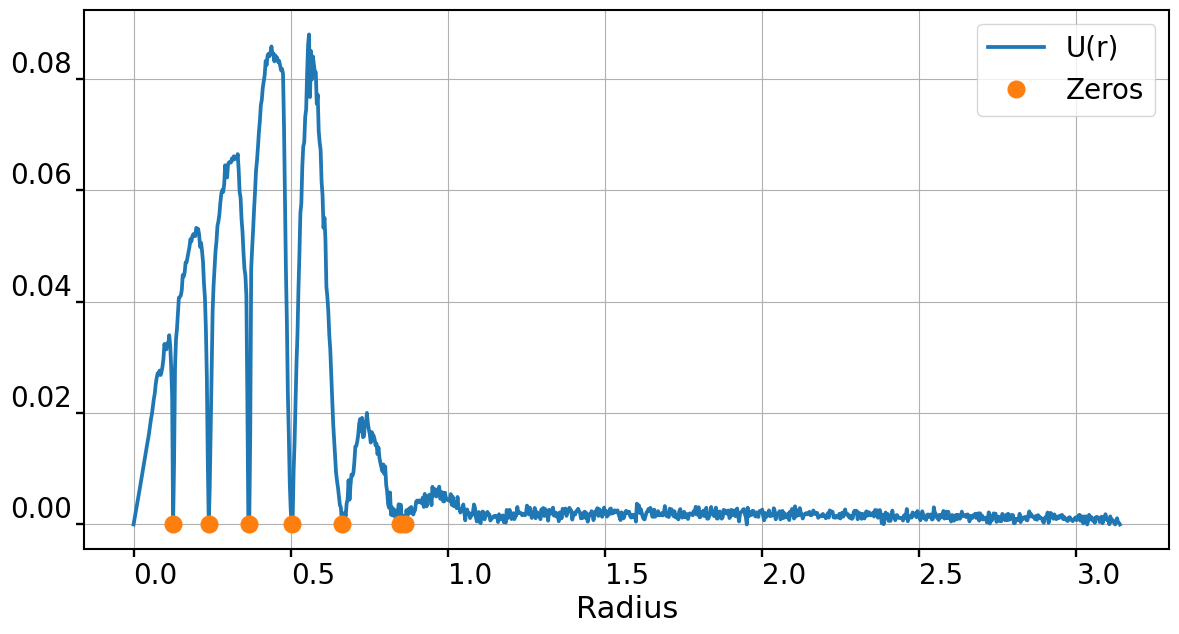

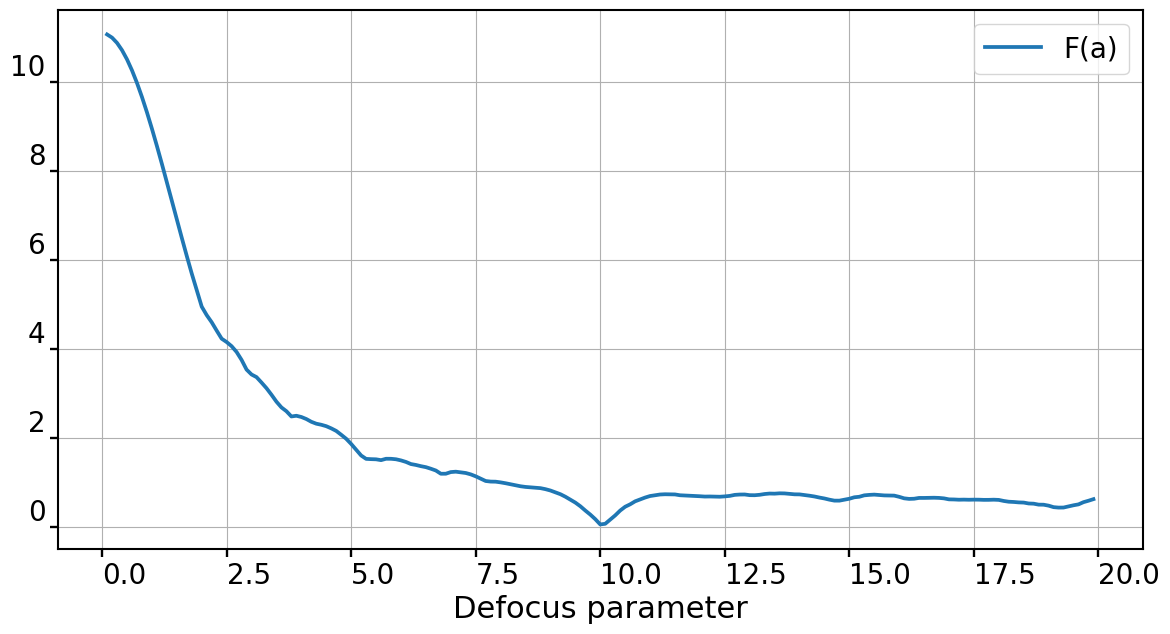

In [6]:
Scripts.estimate_defocus_param(image_blurred, selected_sample.average_angled_spectrum_k, selected_sample.average_angled_spectrum_b,
                               selected_sample.zeros_range_ratio, plot_folder=selected_sample.sample_folder)

### <span>**OTF preparation**</span>

In [ ]:
psf = OTF.create_psf(image_blurred.shape, selected_sample.defocus_param)
otf = OTF.psf2otf(psf)
psf /= np.max(psf)

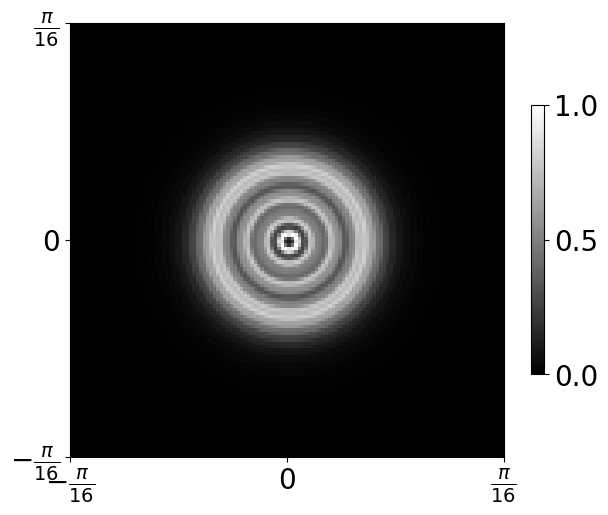

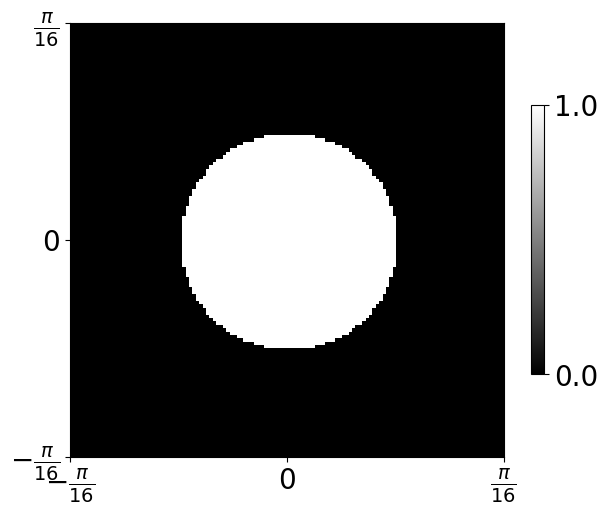

In [9]:
Plotting.plot_image(Utils.image_crop_corners(fftp.fftshift(psf), ratio=0.46875), axes_labels=[r'$-\frac{\pi}{16}$', 0, r'$\frac{\pi}{16}$'],
                    plot_file='Results_(VKR)/PSF.svg')
Plotting.plot_image(Utils.image_crop_corners(fftp.fftshift(psf>0.1), ratio=0.46875), axes_labels=[r'$-\frac{\pi}{16}$', 0, r'$\frac{\pi}{16}$'],
                    plot_file='Results_(VKR)/Cylinder.svg')

### <span>**Image restoration**</span>

Blind deconvolution

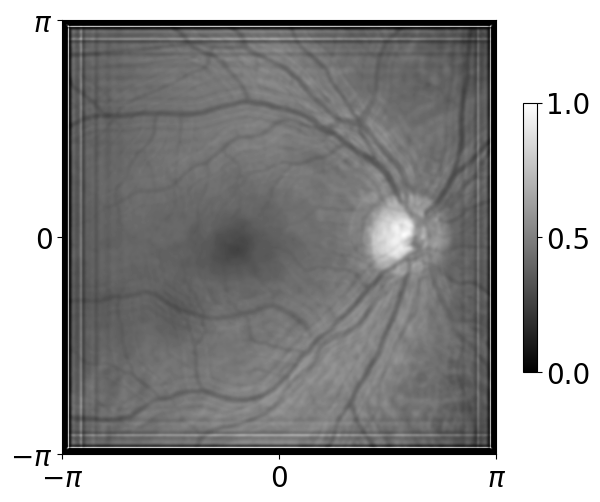

In [10]:
image_restored_blind1 = Utils.image_normalize(skimage.restoration.richardson_lucy(image_blurred,
                                                                                 fftp.fftshift(psf>0.1),
                                                                                 num_iter=selected_sample.deconv_iters))
Plotting.plot_image(image_restored_blind1)

In [11]:
Utils.image_save(Utils.image_crop_corners(image_restored_blind1, ratio=selected_sample.crop_ratio), selected_sample.sample_folder + '8, blind deconv(1).png')

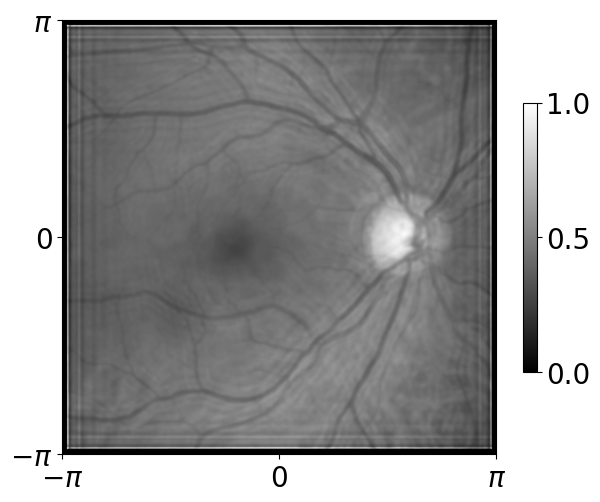

In [11]:
image_restored_blind2 = Utils.image_normalize(skimage.restoration.richardson_lucy(image_blurred,
                                                                                 fftp.fftshift(psf),
                                                                                 num_iter=selected_sample.deconv_iters))
Plotting.plot_image(image_restored_blind2)

In [10]:
Utils.image_save(Utils.image_crop_corners(image_restored_blind2, ratio=selected_sample.crop_ratio), selected_sample.sample_folder + '8, blind deconv(2).png')

Both methods at best parameters

In [13]:
image_restored_bisp = BispectralMethod.bispectral_method(image_blurred, otf, selected_sample.bispectral_alpha)

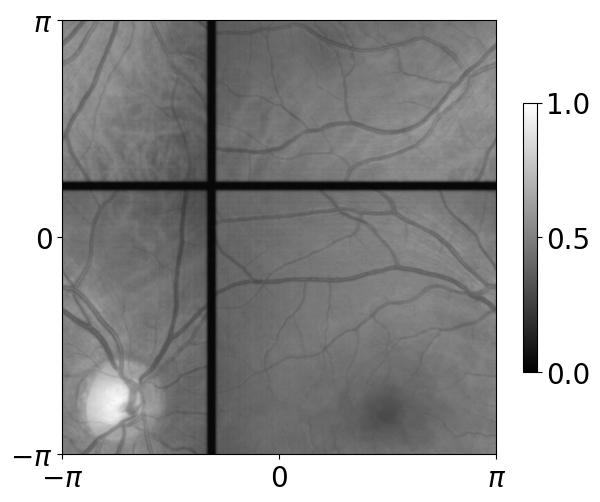

In [14]:
image_restored_bisp = np.roll(image_restored_bisp, (0, -1), axis=(1, 0))
Plotting.plot_image(image_restored_bisp)

In [19]:
Utils.image_save(Utils.image_crop_corners(image_restored_bisp, ratio=selected_sample.crop_ratio), selected_sample.sample_folder + '6, bisp.png')

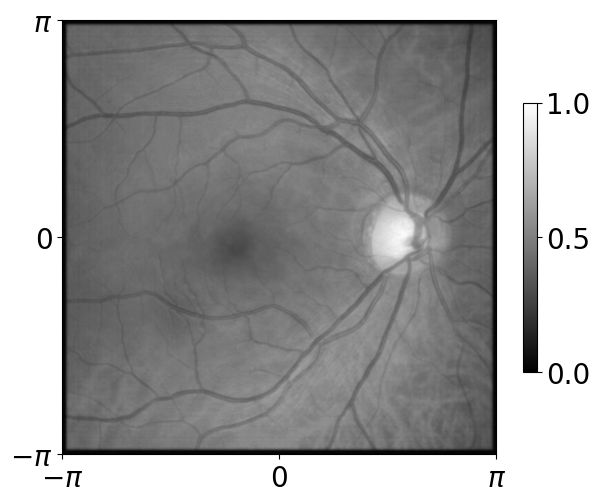

In [15]:
image_restored_tich = TikhonovMethod.tikhonov_regularization_method(image_blurred, otf, selected_sample.tikhonov_alpha, selected_sample.tikhonov_r)
Plotting.plot_image(image_restored_tich)

In [13]:
Utils.image_save(Utils.image_crop_corners(image_restored_tich, ratio=selected_sample.crop_ratio), selected_sample.sample_folder + '7, tich.png')

### <span>**Metrics**</span>

In [3]:
Scripts.compair_results(selected_sample.sample_folder)

Blind deconvolution 1 metrics:
MSE 0.001042
SSIM 0.898767
Blind deconvolution 2 metrics:
MSE 0.000823
SSIM 0.912524
Bispectral method metrics:
MSE 0.000290
SSIM 0.871192
Tikhonov method metrics:
MSE 0.000135
SSIM 0.926649
